In [1]:
import numpy as np
from curve import Curve
import matplotlib.pyplot as plt

In [3]:
from ipywidgets import FileUpload
upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

In [4]:
with open('1hk7.pdb', 'w+b') as file:
    file.write(upload.data[0])

[1.00177161 1.01685989 1.03194817 1.04703644 1.06212472 1.077213
 1.09230128 1.10738956 1.12247783 1.13756611 1.15265439 1.16774267
 1.18283095 1.19791923 1.2130075  1.22809578 1.24318406 1.25827234
 1.27336062 1.28844889 1.30353717 1.31862545 1.33371373 1.34880201
 1.36389028 1.37897856 1.39406684 1.40915512 1.4242434  1.43933167
 1.45441995 1.46950823 1.48459651 1.49968479 1.51477307 1.52986134
 1.54494962 1.5600379  1.57512618 1.59021446 1.60530273 1.62039101
 1.63547929 1.65056757 1.66565585 1.68074412 1.6958324  1.71092068
 1.72600896 1.74109724 1.75618552 1.77127379 1.78636207 1.80145035
 1.81653863 1.83162691 1.84671518 1.86180346 1.87689174 1.89198002
 1.9070683  1.92215657 1.93724485 1.95233313 1.96742141 1.98250969
 1.99759797 2.01268624 2.02777452 2.0428628  2.05795108 2.07303936
 2.08812763 2.10321591 2.11830419 2.13339247 2.14848075 2.16356902
 2.1786573  2.19374558 2.20883386 2.22392214 2.23901041 2.25409869
 2.26918697 2.28427525 2.29936353 2.31445181 2.32954008 2.344628

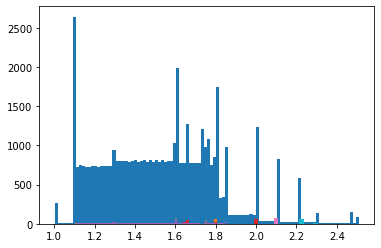

In [2]:
import h5py
from autosplit import autosplit

test_curves = autosplit('/home/kris/proj/.data/tweez/yhsp2.h5')

fdcurves = {}  # clear fdcurces
for key, curve in test_curves.items():
    fdcurves[key] = Curve(key, *[curve[dname]
                                for dname in ['full_dist', 'full_force',
                                              'pull_dist', 'pull_force',
                                              'rlx_dist', 'rlx_force']])

{'identifier': 'curve_44', 'dist_data': array([0.1143142 , 0.1127057 , 0.12046914, ..., 0.10700536, 0.11321854,
       0.11662951]), 'force_data': array([16.91836603, 16.76505123, 16.57939678, ..., 17.55626563,
       17.19874033, 16.83994092]), 'split': 2, 'pull_f': array([16.91836603, 16.76505123, 16.57939678, ..., 60.59669062,
       60.43069877, 60.9335047 ]), 'pull_d': array([0.1143142 , 0.1127057 , 0.12046914, ..., 0.96187842, 0.96248195,
       0.96157486]), 'rlx_f': array([40.45071152, 40.53938678, 40.60942252, ..., 17.52310914,
       17.21064334, 16.82452351]), 'rlx_d': array([0.97397975, 0.96706857, 0.96756543, ..., 0.10907485, 0.11660643,
       0.12340746])}


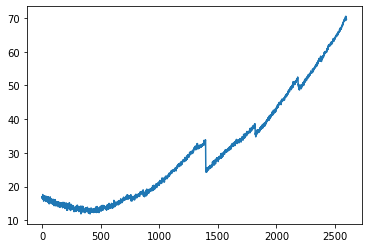

In [3]:
test = fdcurves['curve_44']
print(vars(test))
plt.plot(test.pull_f[:-100])

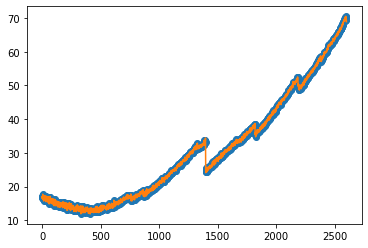

In [4]:
from scipy.interpolate import CubicSpline
x = np.arange(len(test.pull_f))[:-100]
y = test.pull_f[:-100]
cs = CubicSpline(x,y)
xs = np.arange(0,len(y),0.1)
plt.plot(x,y,'o')
plt.plot(xs,cs(xs))
#plt.xlim((1000,1200))

[   0.  650. 1299. 1340. 1381. 1422. 1462. 1624. 1949. 2598.]


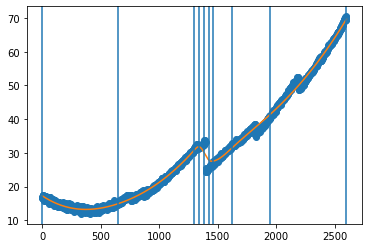

In [5]:
from scipy.interpolate import UnivariateSpline
us = UnivariateSpline(x,y, k=3, s=2000)
plt.plot(x,y,'o')
plt.plot(xs,us(xs))
for knot in us.get_knots():
    plt.axvline(knot)
#plt.xlim((1000,1200))
print(us.get_knots())

(array([ 102,  216,  348,  409, 1396, 1818, 2185]), -1.5735955377527997)
[1396]


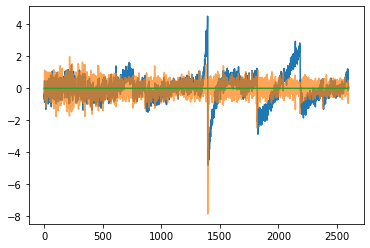

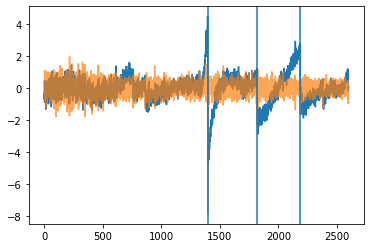

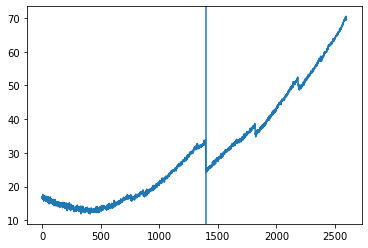

In [15]:
from event_finding import find_transitions
plt.plot(y - us(x))
plt.plot(np.diff(y-us(x)),alpha=0.7)
us2 = UnivariateSpline(x, y - us(x), k=3, s=2000)
plt.plot(us2(x))
plt.figure()
plt.plot((y - us(x)) - us2(x))
plt.plot(np.diff((y - us(x)) - us2(x)), alpha=0.7)
print(find_transitions(y - us(x)))
transitions = find_transitions(y[500:]-us(x[500:]))[0] + 500
for t in transitions:
    plt.axvline(t)
plt.figure()
plt.plot(y)
other = find_transitions(y[500:])[0] + 500
print(other)
plt.axvline(other)

(1600.0, 1700.0)

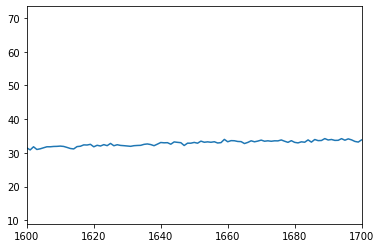

In [7]:
dips = x[:-1][np.diff(y-us(x)) < -3]
plt.plot(x,y)
for dip in dips:
    plt.axvline(dip)
plt.xlim((1600, 1700))

In [8]:
import lumicks.pylake as lk
handle_estimates = \
    {'handles/Lp':  # DNA handle persistence length (nm)
      {'value': 15,  # initial estimate
       'upper_bound': 100,  # very wide bounds?
       'lower_bound': 0.0},
     'handles/Lc':  # contour length (um)
      {'value': 0.3},#bp2cl(1040)},  # bp2cl generates a contour length from a number of basepairs.
     'handles/St':  # stretch modulus (pN)
      {'value': 300,
       'lower_bound': 250},
     'handles/f_offset':  # force offset (pN)
      {'value': 0,
       'upper_bound': 6,
       'lower_bound': -6,
       'fixed': True}  # if True, the parameter is fixed to the current 'value' field.
    }                 # here we use this entry to turn off the force offset included in the model
protein_estimates = \
     {'protein/Lp':  # unfolded protein persistence length (nm)
      {'value': 0.7,
      'upper_bound': 1.0,
      'lower_bound': 0.6,
      'fixed': False},
     'protein/Lc':  # contour length (um)
      {'value': 0.001,
       'fixed': False}
     }
handles_model = lk.inverted_odijk('handles') + lk.force_offset('handles')

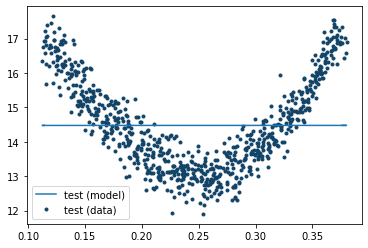

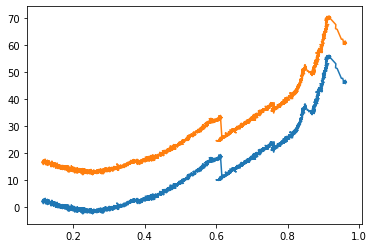

In [9]:
fit = lk.FdFit(handles_model)
fit.add_data('test', test.pull_f[:750], test.pull_d[:750])
fit.fit()
#plt.plot(handles_model(np.arange(min(test.pull_d), max(test.pull_d), 0.01), fit))
fhat = handles_model(np.linspace(min(test.pull_d), max(test.pull_d), len(test.pull_f)), fit)
fit.plot()
plt.figure()
plt.plot(test.pull_d, test.pull_f - fhat)
plt.plot(test.pull_d, test.pull_f)

(array([1392, 1819, 2186]), -0.35174202778624747)
(array([1396, 2634]), -3.04949106879401)


[]

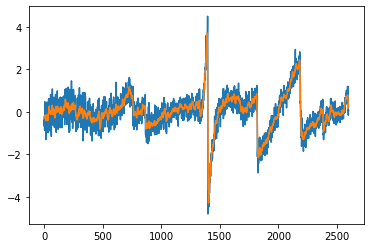

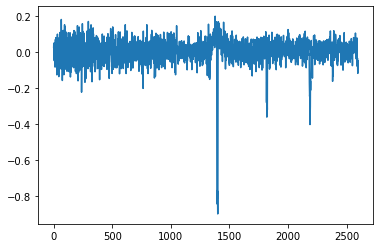

In [10]:
kernel_size = 10 
kernel = np.ones(kernel_size) / kernel_size
smooth_diffs = np.convolve(y - us(x), kernel, mode='same')
plt.plot(y-us(x))
plt.plot(smooth_diffs)
plt.figure()
plt.plot(np.diff(smooth_diffs))
print(find_transitions(smooth_diffs))
print(find_transitions(test.pull_f))
plt.plot()

(array([2535, 2580]), -0.21435900016471898)


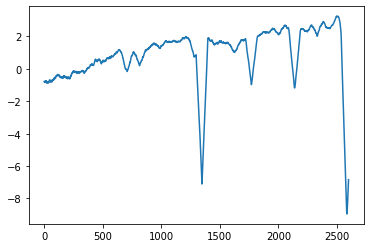

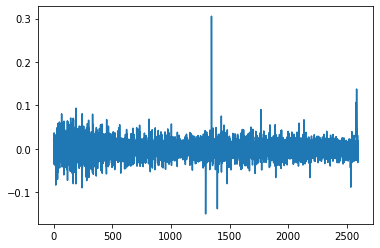

In [11]:
def average_around(data, index, half_n=10):
    # this needs some sanity checks around the indexing
    left = data[index - half_n:index]
    right = data[index:index + half_n]
    return np.mean(right) - np.mean(left)

davgs = []
half_n = 50
for index in range(half_n, len(test.pull_f) - half_n):
    davgs.append(average_around(test.pull_f, index, half_n=half_n))
plt.plot(davgs) 
print(find_transitions(np.asarray(davgs)))
plt.figure()
plt.plot(np.diff(np.diff(davgs)))

In [12]:
import ruptures as rpt
algo = rpt.Binseg(model='l2').fit(np.diff(davgs))
bkps = algo.predict(n_bkps=5)
print(bkps)

[1295, 1345, 1400, 2530, 2585, 2598]


[   0.    3.    6.   11.   13.   14.   16.   18.   19.   21.   24.   26.
   31.   34.   36.   41.   44.   47.   49.   50.   52.   57.   60.   62.
   65.   67.   70.   72.   77.   80.   82.   83.   84.   85.   87.   88.
   93.   98.  100.  101.  102.  103.  108.  111.  113.  118.  120.  121.
  123.  126.  128.  131.  133.  135.  136.  138.  143.  145.  146.  148.
  151.  152.  153.  156.  158.  163.  166.  169.  172.  174.  177.  179.
  184.  187.  189.  192.  194.  196.  197.  199.  204.  206.  207.  209.
  214.  215.  216.  217.  218.  219.  221.  222.  224.  229.  231.  232.
  233.  234.  237.  239.  240.  241.  242.  244.  247.  250.  253.  255.
  260.  265.  270.  273.  275.  278.  280.  285.  288.  290.  292.  293.
  294.  295.  297.  298.  300.  303.  305.  308.  310.  313.  315.  320.
  325.  327.  328.  331.  333.  334.  336.  338.  339.  341.  344.  346.
  347.  348.  349.  351.  354.  356.  366.  369.  371.  372.  377.  382.
  387.  392.  395.  397.  400.  402.  407.  409.  4

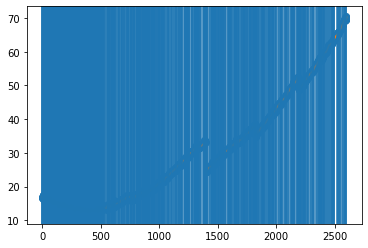

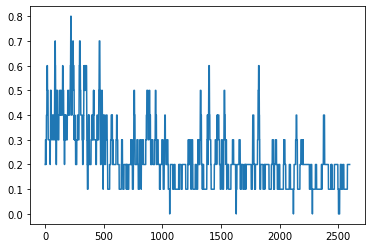

In [13]:
newus = UnivariateSpline(x,y, k=3, s=200)
plt.plot(x,y,'o')
plt.plot(xs,newus(xs))
for knot in newus.get_knots():
    plt.axvline(knot)
#plt.xlim((1000,1200))
print(newus.get_knots())
sparse_knots = np.zeros(len(y))
for knot in newus.get_knots():
    sparse_knots[int(knot)] = 1
plt.figure()
#plt.plot(sparse_knots)
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
avg_knots = np.convolve(sparse_knots, kernel, mode='same')
plt.plot(avg_knots)
print('aaa')
print(find_transitions(avg_knots))
print(np.arange(len(avg_knots))[avg_knots > 0.2])

898 890 903
9.15079156769108
0
887 879 896
7.128313091099429
1
874 870 883
6.58184967440927
2
867 861 876
6.4067172413056745
3
859 853 868
5.702169146062932
4
851 845 864
4.629596693290246
5
841 837 850
4.671684941785738
6
835 829 840
4.677522654526992
7
828 822 833
4.827740247277696
8
821 815 826
3.8769780676246697
9
814 808 819
3.972241204690267
10
801 798 807
3.0490294382154133
11
795 788 801
1.6299974564408473
12
1097 1094 1103
2.9371346896764976
13
1081 1081 1082
-0.16527951013302555
14
788 788 789
0.010816417296890535
15
1082 1079 1088
1.7498214420205258
16
1068 1060 1084
0.6759511692959776
17
1391 1384 1407
2.1527606841639653
18
0 0 0
55.55846304232166
19
0 0


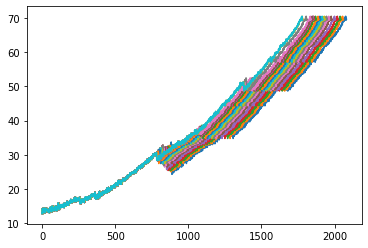

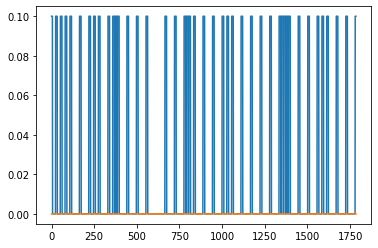

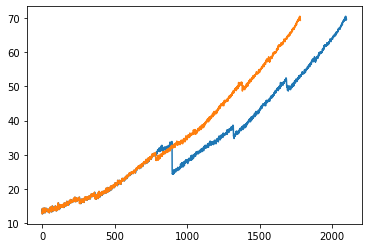

In [14]:
# highest knot-density => shift right-half upward to where continuous with left half
from copy import deepcopy
from util import thresholding_algo
new_y = deepcopy(y[500:])
#new_y = deepcopy(y[500:])
new_x = np.arange(len(new_y))
#new_x = deepcopy(x)
#plt.plot(new_y)
for i in range(20):
    newus = UnivariateSpline(new_x,new_y, k=3,s=200)
    sparse_knots = np.zeros(len(new_y))
    for knot in newus.get_knots():
        sparse_knots[int(knot)] = 1
    kernel_size = 10
    kernel = np.ones(kernel_size) / kernel_size
    avg_knots = np.convolve(sparse_knots, kernel, mode='same')
    densamax = np.argmax(avg_knots) # change to np.where(...) with a binned set
    first = densamax
    last = densamax
    thrsig = thresholding_algo(avg_knots, len(new_y) // 4, 2., 0)['signals']
    for j in range(last,len(y)):
        if thrsig[j] >= 1:
            last = j
        else:
            break
    for j in reversed(range(0,first)):
        if thrsig[j] >= 1:
            first = j
        else:
            break
    print(densamax, first, last)
    delta = new_y[first - 2] - new_y[last + 2]
    print(delta)
    if delta > 0 and first > last and first > 0:
        new_y[last:] += new_y[first-2] - new_y[last+2]
    new_y = np.delete(new_y, range(first-2, last+2), 0)
    new_x = np.arange(len(new_y))
    plt.plot(new_y)
    print(i)

#plt.plot(y)
#plt.plot(new_y)
plt.figure()
plt.plot(avg_knots)
plt.plot(thresholding_algo(avg_knots, len(y) // 4, 2., 0)['signals'])
densamax = np.argmax(avg_knots)
first = densamax
last = densamax
for i in range(last,len(y)):
    if thrsig[i] >= 1:
        last = i
    else:
        break
for i in reversed(range(0,first)):
    if thrsig[i] >= 1:
        first = i
    else:
        break

print(first, last)
new_y[last:] += new_y[first] - new_y[last]
new_y = np.delete(new_y, range(first,last), 0)
plt.figure()
plt.plot(y[500:])
plt.plot(new_y)